In [1019]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import pytz
import matplotlib.pyplot as plt
import re

## 思路說明
Question:
1. 請根據資料回答，哪些顧客有相似的消費行為，為什麼?
   - 以CustomerID = 17347.0 為例
   - 從自定義的Feature中，找出其他顧客也有類似的行為模式，以此作為顧客分群依據，找出相似顧客10位，相似度達0.99以上
     CustomerID = [18220.0,18113.0,16148.0,12346.0,15668.0,14090.0,17650.0,16432.0,14212.0,17628.0]
    
2. 呈第四題，請推薦以下顧客，接下來可能購買的商品清單，理由是?
   - 顧客17347.0會想買的商品清單，
     StockCode = ['84946', '21212', '84991', '21977', '21175', '21232', '47566', '21231','84947', '20724']
   - 用A表(User-Item)，計算這些相似用戶購買各個商品的次數，轉換成機率值，取機率值前10高的商品，推薦給顧客17347.0

Data ETL:
0. 檢查每個Column資料是否有缺失值或異常值
1. Stock Code有非編碼資料(Ex: 'POST','M','DOT'...)觀察後應該是運費
2. Invoice如果取消購買，會在前面冠C

資料可視化觀察:
1. Unit Price(log)

Data EDA:
0. 一般用戶、企業用戶分群(Kmeans)
1. 顧客每次消費總額
2. 顧客消費時間分類(早、中、晚、凌晨)
3. 一天內購買多次
4. 顧客平均購買商品總數
5. 同一筆訂單的消費商品做協同分析
6. 商品顏色分類(onehot)
7. 國家顧客分群(onehot)

演算法:
1. Kmeans
    繼續選用Kmeans做非監督式的用戶分群，但從silhouett的分數結果來看，分數最高的落在n=2群，之後一路下降，顯示分群結果並不好。
2. 協同過濾
    A = B x C
    - A: User-Item Sheet
    - B: User-Feature Sheet
    - C: Feature-Item Sheet
    想透過SVD的方式來算出用戶對商品的喜好度，但最後C表沒做完
3. 在C表沒做完的情況下，
    - 用B表(User-Feature)做用戶間的Similarity
    - 改良A表(User-Item)，element為用戶購買商品的次數
    - 透過A表、B表，可以做到相似顧客的計算和推薦顧客商品的結果
      兩個Function
      - findSimilarCustomer(...) : 找出相似顧客
      - findRecommendItem(...)   : 其他相似用戶也買過頻率高的商品
    

In [1101]:
def plot_hist(nd,b_nums):
    plt.style.use('ggplot')
    plt.hist(nd, bins=b_nums)
    return plt

## 讀入檔案

In [86]:
raw_data = pd.read_excel('/Users/brianhung/Documents/Reseme/gogolook/d3_OnlineRetail.xlsx')

## 資料觀察

In [87]:
raw_data.describe(include=['O'])

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


In [88]:
raw_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [89]:
raw_data.head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [90]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [91]:
raw_data.groupby('Country').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
Country,,,,,,,
Australia,1259,1259,1259,1259,1259,1259,1259
Austria,401,401,401,401,401,401,401
Bahrain,19,19,19,19,19,19,17
Belgium,2069,2069,2069,2069,2069,2069,2069
Brazil,32,32,32,32,32,32,32
Canada,151,151,151,151,151,151,151
Channel Islands,758,758,758,758,758,758,758
Cyprus,622,622,622,622,622,622,622
Czech Republic,30,30,30,30,30,30,30


# Data ETL & EDA

In [224]:
train_data = raw_data.copy()

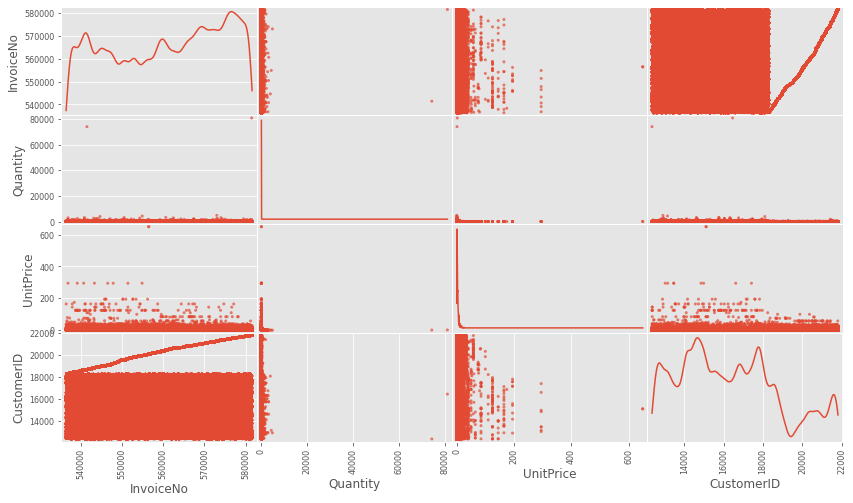

In [1794]:
pd.plotting.scatter_matrix(train_data, alpha=0.7, figsize=(14,8), diagonal='kde')
plt.show()

## CustomerID

In [225]:
"""
將CustomerID is null的設定為虛擬Customer,並填補缺失值
1. 新增欄位['VCustomer']判斷是否為虛擬Customer
2. 接續['CustomerID']的最大值，填補CustomerID的缺失值
"""
train_data['VCustomer'] = 'F'
train_data.loc[train_data['CustomerID'].isnull(),'VCustomer'] = 'T'

max_cust_id = max(raw_data['CustomerID'])
for k,group in train_data.loc[train_data['CustomerID'].isnull()].groupby('InvoiceNo'):
    max_cust_id += 1
    train_data.loc[(train_data['InvoiceNo']==k),'CustomerID'] = max_cust_id

## InvoiceNo

In [226]:
"""
把InvoiceNo變成純粹的數字Invoice資料，C開頭的"取消訂單"，新增一個欄位'OrderDeal'
1. 新增欄位'OrderDeal':成交的訂單為'T',取消的訂單為'F'
2. 把InvoiceNo變成純粹的數字Invoice資料，把C去掉。
"""
train_data['OrderDeal'] = 'T'
mask = train_data['InvoiceNo'].str.startswith('C').notnull()
train_data.loc[mask,'OrderDeal'] = 'F'
train_data['InvoiceNo'] = [(i if type(i) is int else int(i[1:]) )for i in train_data['InvoiceNo']]

## Quantity

In [227]:
"""
移除商品數量<0的異常列
"""
train_data = train_data[train_data['Quantity']>0]

## UnitPrice

In [234]:
"""
移除UnitPrice = 0 的異常列
"""
train_data = train_data[train_data['UnitPrice']>0]

## StockCode

In [256]:
"""
移除StockCode不是數字開頭的異常值(看起來是運費 Ex:POST,DOT,M,...)
"""
train_data['StockCode'] = train_data['StockCode'].astype('str')
train_data = train_data[~train_data['StockCode'].str.contains(re.compile('^[a-zA-Z]{1}.*$'))]

## TimeZone處理

In [ ]:
train_data['TimeZoneGMT'] = ''
train_data.loc[train_data['Country'] == 'Australia','TimeZoneGMT'] = 'Etc/GMT+10'
train_data.loc[train_data['Country'] == 'Austria','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Bahrain','TimeZoneGMT'] = 'Etc/GMT+3'
train_data.loc[train_data['Country'] == 'Belgium','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Brazil','TimeZoneGMT'] = 'Etc/GMT-3'
train_data.loc[train_data['Country'] == 'Canada','TimeZoneGMT'] = 'Etc/GMT-4'
train_data.loc[train_data['Country'] == 'Channel Islands','TimeZoneGMT'] = 'Etc/GMT+0'
train_data.loc[train_data['Country'] == 'Cyprus','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'Czech Republic','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Denmark','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'EIRE','TimeZoneGMT'] = 'Etc/GMT+0'
train_data.loc[train_data['Country'] == 'European Community','TimeZoneGMT'] = 'Etc/GMT+0'
train_data.loc[train_data['Country'] == 'Finland','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'France','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Germany','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Greece','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Hong Kong','TimeZoneGMT'] = 'Etc/GMT+8'
train_data.loc[train_data['Country'] == 'Iceland','TimeZoneGMT'] = 'Etc/GMT+0'
train_data.loc[train_data['Country'] == 'Israel','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'Italy','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Japan','TimeZoneGMT'] = 'Etc/GMT+9'
train_data.loc[train_data['Country'] == 'Lebanon','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'Lithuania','TimeZoneGMT'] = 'Etc/GMT+3'
train_data.loc[train_data['Country'] == 'Malta','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Netherlands','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Norway','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Poland','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Portugal','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'RSA','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'Saudi Arabia','TimeZoneGMT'] = 'Etc/GMT+3'
train_data.loc[train_data['Country'] == 'Singapore','TimeZoneGMT'] = 'Etc/GMT+8'
train_data.loc[train_data['Country'] == 'Spain','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'Sweden','TimeZoneGMT'] = 'Etc/GMT+2'
train_data.loc[train_data['Country'] == 'Switzerland','TimeZoneGMT'] = 'Etc/GMT+1'
train_data.loc[train_data['Country'] == 'USA','TimeZoneGMT'] = 'Etc/GMT-5'
train_data.loc[train_data['Country'] == 'United Arab Emirates','TimeZoneGMT'] = 'Etc/GMT+4'
train_data.loc[train_data['Country'] == 'United Kingdom','TimeZoneGMT'] = 'Etc/GMT+0'
train_data.loc[train_data['Country'] == 'Unspecified','TimeZoneGMT'] = 'Etc/GMT+0'

## InvoiceNoDate

In [1245]:
"""
1. 觀察儲存時間是Invoice開立的系統時間，要做分類應該要改成LocalTime，
   所以要先把時間轉換成國家當地的LocalTime(以英國時間UTC+0為準)

2. 把時間區段分類為"Morning","Afternoon","Evening","Night"
    "Morning"   - 06:00~12:00
    "Afternoon" - 13:00~18:00
    "Evening"   - 18:00~23:00
    "Night"     - 23:00~06:00
"""
# InvoiceDate轉換為當地時間LocalInvoiceDate
train_data['LocalInvoiceDate'] = '2020-01-01 00:00:00'
for k,group in train_data.groupby('InvoiceNo'):
    invoice_date = datetime.strptime(str(list(group['InvoiceDate'])[0]),'%Y-%m-%d %H:%M:%S')
    local_tz = pytz.timezone(list(group['TimeZoneGMT'])[0])
    local_time = pytz.utc.localize(invoice_date, is_dst=None).astimezone(local_tz)
    train_data.loc[train_data['InvoiceNo']==k,'LocalInvoiceDate'] = invoice_date.astimezone(local_tz)

# 將時間做區段分類 - 
# "Morning" - 06:00~12:00
# "Afternoon" - 12:00~18:00
# "Evening" - 18:00~12:00
# "Night" - 12:00~12:00
train_data['timeClass'] = 'Morning'
for k,group in train_data.groupby('InvoiceNo'):
    group_date = train_data.loc[train_data['InvoiceNo']==k]['InvoiceDate']
    t = group_date.iloc[0]
    tp6 = datetime(t.year,t.month,t.day,6,0,0)
    tp12 = datetime(t.year,t.month,t.day,12,0,0)
    tp18 = datetime(t.year,t.month,t.day,18,0,0)
    tp24 = datetime(t.year,t.month,t.day,0,0,0)
    if t >= tp24 and t < tp6:
        train_data.loc[train_data['InvoiceNo']==k,'timeClass'] = 'Night'
    elif t >= tp6 and t < tp12:
        train_data.loc[train_data['InvoiceNo']==k,'timeClass'] = 'Morning'
    elif t >= tp12 and t < tp18:
        train_data.loc[train_data['InvoiceNo']==k,'timeClass'] = 'Afternoon'
    else:
        train_data.loc[train_data['InvoiceNo']==k,'timeClass'] = 'Evening'

## 從UnitPrice區分低中高價商品

log2(mean,std) =  (2.1713325030218207, 2.0834623195333353)


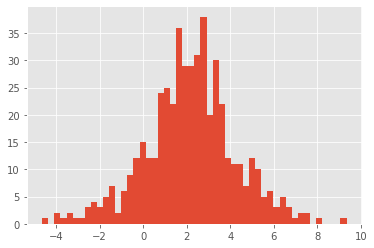

('h_nums', 'm_nums', 'h_nums')  =  (72, 353, 71)


In [613]:
"""
新增欄位"UnitPriceClass"
取出資料中的UnitPrice，做log2後計算mean和std
"H"   - 大於平均值一倍標準差
"L"    - 小於平均值一倍標準差
"M" - 平均值三倍標準差內的商品 
"""

unit_price_group = train_data.groupby(['UnitPrice'])
unit_price = np.array(list(unit_price_group.groups.keys()))
unit_price_log2 = np.log2(unit_price)
up_std = np.std(unit_price_log2)
up_mean = np.mean(unit_price_log2)
print("log2(mean,std) = ",(up_mean,up_std))
plt = plot_hist(unit_price_log2,50)
plt.show()

# 取標準差區間定義高價與低價的值
std_inv = 1
high_price = up_mean + std_inv*up_std
low_price = up_mean - std_inv*up_std
# print((low_price,high_price))

# 還原價格取exp2
high_price = np.exp2(high_price)
low_price = np.exp2(low_price)

# 計算高中低價位的商品數量
h_nums = len(unit_price[unit_price > high_price])
l_nums = len(unit_price[unit_price < low_price])
m_nums = len(unit_price) - h_nums - l_nums
print(('h_nums','m_nums','h_nums')," = ",(l_nums,m_nums,h_nums))

# 商品價格分類
train_data['UnitPriceClass'] = 'M'
train_data.loc[train_data['UnitPrice'] >= high_price,'UnitPriceClass'] = 'H'
train_data.loc[train_data['UnitPrice'] <= low_price,'UnitPriceClass'] = 'L'

## StockCode從商品銷售數量看熱銷款、冷門款

[  860   303   193     5    16    17  1296  2867  2231  1615   143  6591
 23826  2091   464   321   314   645  2844  3954   778    87   127    33
   200   228   240   451     3  2892    30  1773  1244 13328   662  1273
    84   840    98  8900    68  1461   504   479  1166    49   475  5800
   700    25  7226  4075    20    28   371  4563   200   660    25    50
     7    29    15     7    60    29  3333  3821  3048   815  3104  1438
  4994  1398     7    13    40   472  3380    72 23056    24    81   323
   525   421   463    68   448   535   155  2427     6  1525   200   225
  1264   423  4032   109]


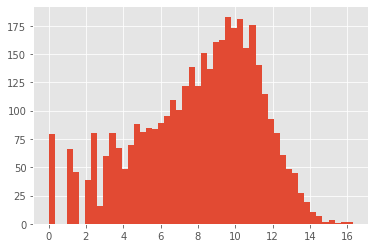

(qt_mean,qt_medium) =  (8.010660306176021, 8.558415637949356) ;qt_std =  3.257000087411803
log2數量:(low_qt,high_qt) =  (4.753660218764218, 11.81541572536116)
還原數量:(low_qt,high_qt) =  (26.977041190022607, 3604.0810132425213)


In [655]:
"""
新增欄位"StockCodeClass"
取出資料中的StockCode，計算單一商品總銷售量後，做log2後計算mean和std
"H"   - 大於平均值一倍標準差
"L"    - 小於平均值一倍標準差
"M" - 平均值一倍標準差內的商品 
"""
stock_code_group = train_data.groupby(['StockCode'])
quantity = np.array(list(stock_code_group.sum()['Quantity']))
quantity_log2 = np.log2(quantity)

# 作圖觀察Hist
plt = plot_hist(quantity_log2,50)
plt.show()

qt_std = np.std(quantity_log2)
qt_mean = np.mean(quantity_log2)
qt_medium = np.median(quantity_log2)
print("(qt_mean,qt_medium) = ",(qt_mean,qt_medium),";qt_std = ",qt_std)

# 取標準差區間定義熱銷與冷門的值
std_inv = 1
high_qt = qt_medium + std_inv*qt_std
low_qt = qt_mean - std_inv*qt_std
print("log2數量:(low_qt,high_qt) = ",(low_qt,high_qt))

# 還原數量取exp2
high_qt = np.exp2(high_qt)
low_qt = np.exp2(low_qt)
print("還原數量:(low_qt,high_qt) = ",(low_qt,high_qt))

# 單一商品總銷售量分類
train_data['StockCodeClass'] = 'M'
stock_code_qt = stock_code_group.sum()['Quantity']
stock_code_key_list = list(stock_code_qt.keys())
for i in stock_code_key_list:
    if stock_code_qt[i] >= high_qt:
        train_data.loc[train_data['StockCode']==i,'StockCodeClass'] = 'H'
    elif stock_code_qt[i] <= low_qt:
        train_data.loc[train_data['StockCode']==i,'StockCodeClass'] = 'L'

## CustomerId每次的消費商品總數,不同品項數目,消費總額

In [739]:
"""
建立CutomerId的子表:invoice_sheet
子表內記錄消費者每次的消費商品總數,商品數量,消費總額
"""
# 子表 customer_id_sheet
invoice_sheet = pd.DataFrame(columns=['CustomerID','InvoiceNo'])

# 消費商品總數
invoice_sheet['TotalQts'] = 0

# 不同品項數目
invoice_sheet['StockQts'] = 0

# 消費總額
invoice_sheet['CheckAmount'] = 0

customer_qt_nums = train_data.groupby(['InvoiceNo','CustomerID'])
for (ivn,cid), group in customer_qt_nums:
    total_qts = sum(group['Quantity'])
    times = len(group['Quantity'])
    
    check_amount = 0
    for idx,row in group.iterrows():
        check_amount += row['Quantity']*row['UnitPrice']
    
    new_row = pd.DataFrame([(cid,ivn,total_qts,times,check_amount)],columns = ['CustomerID','InvoiceNo','TotalQts','StockQts','CheckAmount'])
    invoice_sheet = invoice_sheet.append(new_row,ignore_index=True)

,CustomerID,InvoiceNo,TotalQts,StockQts,CheckAmount
0,17850.0,536365,40,7,139.12
1,17850.0,536366,12,2,22.20
2,13047.0,536367,83,12,278.73
3,13047.0,536368,15,4,70.05
4,13047.0,536369,3,1,17.85
...,...,...,...,...,...
19768,13777.0,581583,76,2,124.60
19769,13777.0,581584,120,2,140.64
19770,15804.0,581585,278,21,329.05
19771,13113.0,581586,66,4,339.20


## CustomerID消費頻率

In [1469]:
"""
消費頻率定義：平均間隔幾日會消費一次
建立子表:customer_id_sheet
"""
customer_id_sheet = pd.DataFrame(columns=['CustomerID'])
customer_id_sheet.set_index('CustomerID',inplace=True)
customer_id_sheet['BuyFreq'] = 0

cid_group = invoice_sheet.groupby(['CustomerID'])
for cid,group in cid_group:

    total_ivn = len(group)
    # 如果CustomerId只有一筆消費記錄，則消費頻率為預設值:0
    if total_ivn == 1:
        new_row = pd.DataFrame([(cid,0)],columns=['CustomerID','BuyFreq'])
        customer_id_sheet = customer_id_sheet.append(new_row,ignore_index=True)
        continue
    ivn_list = list(group['InvoiceNo'])
    day_interval = 0
    for i in range(len(ivn_list)):
        # 第一筆時間跳過
        if i == 0:
            continue
        # 從第二筆時間開始計算間隔天數總和
        pr_date = train_data[train_data['InvoiceNo']==ivn_list[i-1]]['LocalInvoiceDate'].iloc[0]
        cur_date = train_data[train_data['InvoiceNo']==ivn_list[i]]['LocalInvoiceDate'].iloc[0]
        day_interval += (cur_date-pr_date).days
    # 計算平均間隔天數並存進子表:customer_id_sheet
    avg_day = day_interval/(len(ivn_list)-1)
    new_row = pd.DataFrame([(cid,avg_day)],columns=['CustomerID','BuyFreq'])
    customer_id_sheet = customer_id_sheet.append(new_row,ignore_index=True)
            

## 一般用戶和企業用戶區隔

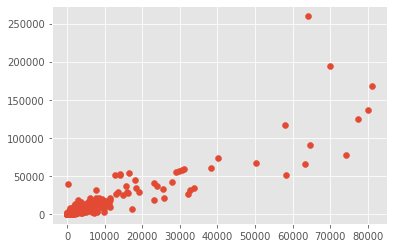

In [1472]:
"""
移除Outlier:14646(CustomerID)
"""
data = invoice_sheet[invoice_sheet['CustomerID']!=14646].groupby('CustomerID').sum()
plt.scatter(data['TotalQts'],data['CheckAmount'])

觀察General結果


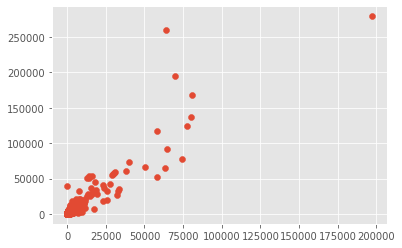

CustomerID = 14646為Outlier,分群前先移除
觀察General結果


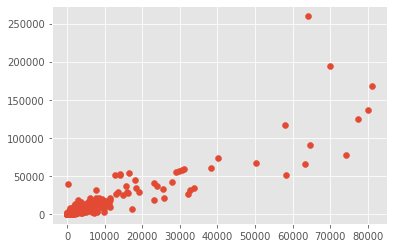

In [1527]:
#觀察結果 CustomerID = 14646為Outlier
#分群前先移除
print("觀察General結果")
tt = invoice_sheet.groupby('CustomerID').sum()
plt.scatter(tt['TotalQts'],tt['CheckAmount'])
plt.show()

# 移除Outlier:14646(CustomerID)
print("CustomerID = 14646為Outlier,分群前先移除")
print("觀察General結果")
data = invoice_sheet[invoice_sheet['CustomerID']!=14646].groupby('CustomerID').sum()
plt.scatter(data['TotalQts'],data['CheckAmount'])
plt.show()

In [1528]:
"""
一般用戶和企業用戶區隔，可從子表invoice_sheet來觀察
用kmeans做分群，群數為2群
"""
from sklearn import cluster
# KMeans 演算法
kmeans_fit = cluster.KMeans(n_clusters = 2).fit(data)

# 印出分群結果
kmeans_labels = kmeans_fit.labels_
print("=============")
print("Kmeans分群結果：")
print(kmeans_labels)
print("=============")

hclust = cluster.AgglomerativeClustering(linkage = 'ward', affinity = 'euclidean', n_clusters = 2)
hclust.fit(data)

# 印出分群結果
hierachy_labels = hclust.labels_
print("=============")
print("hierachy分群結果：")
print(hierachy_labels)
print("=============")
print('KMeans = ',kmeans_labels[kmeans_labels==1],"length = ", len(kmeans_labels[kmeans_labels==1]))
print('Hierachy = ',hierachy_labels[hierachy_labels==0],"length = ",len(hierachy_labels[hierachy_labels==0]))

Kmeans分群結果：
[1 0 0 ... 0 0 0]
hierachy分群結果：
[0 1 1 ... 1 1 1]
KMeans =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] length =  17
Hierachy =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] length =  39


### 將分群結果寫入子表customer_id_sheet

In [1474]:
# Kmeans結果寫入
label_tuple = np.where(kmeans_labels == 1) #Tuple
kmeans_list = list()
for i in label_tuple[0]:
    kmeans_list.append(data.index[i])
    
customer_id_sheet['KmeansCluster'] = 0
for i in kmeans_list:
    customer_id_sheet.loc[customer_id_sheet['CustomerID']==i,'KmeansCluster'] = 1
    
# Hierachy結果寫入
label_tuple = np.where(hierachy_labels == 0)
hierachy_list = list()
for i in label_tuple[0]:
    hierachy_list.append(data.index[i])
    
customer_id_sheet['HierachyCluster'] = 0
for i in hierachy_list:
    customer_id_sheet.loc[customer_id_sheet['CustomerID']==i,'HierachyCluster'] = 1
    
# 把Outlier填回去
customer_id_sheet.loc[customer_id_sheet['CustomerID'] == 14646,'KmeansCluster'] = 1
customer_id_sheet.loc[customer_id_sheet['CustomerID'] == 14646,'HierachyCluster'] = 1

In [1013]:
"""
協同過濾
TODO:
1. User(CustomerID)對Item(StockCode)的onehot encoding
   注意：User沒買過的Item設為None
2. User的Feature有哪些？從三張表來train_data,customer_id_sheet,invoice_sheet
   train_data:Country,timeClass,UnitPriceClass,StockCodeClass
   customer_id_sheet:BuyFreq
   invoice_sheet:平均和最大的(TotalQts,StockQts,CheckAmount)
3. Item的Feature有哪些？
   承2.
"""

'\nTODO:\n1. User對Item的onehot encoding\n'

## Try : Kmeans消費者分群

In [1797]:
"""
消費者分群
Data      : user_feature_sheet
Algorithm : Kmeans,Hierachy
Group     : 10
"""
data = user_feature_sheet.copy()
group = 2 


from sklearn import cluster
# KMeans 演算法
kmeans_fit = cluster.KMeans(n_clusters = group).fit(data)

# 印出分群結果
kmeans_labels = kmeans_fit.labels_
print("=============")
print("Kmeans分群結果：")
print(kmeans_labels)
print("=============")

Kmeans分群結果：
[1 0 0 ... 0 0 0]


### 一般消費者分群(排除企業用戶)
### 用silhouett分數看分群效果

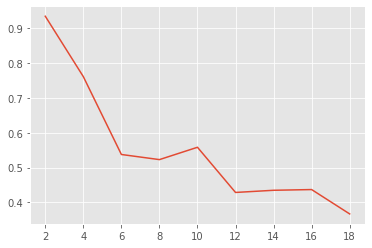

[0.9351220666352623, 0.7615108811320511, 0.5377978501509134, 0.5230749234144542, 0.558519622340358, 0.42869013086462665, 0.4349195064595512, 0.4369997154300179, 0.36699340382728024]


In [1798]:
X = data[data['KmeansCluster']==0]
X = X.drop('KmeansCluster',1)
silhouette_avgs = []
ks = range(2,20,2)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k).fit(X)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# 印出 k = 2 到 20 的 silhouett分數
plt.plot(ks, silhouette_avgs)
plt.show()
print(silhouette_avgs)

## 協同過濾

### 建立User-Stock Matrix

In [1418]:
data_ohe = train_data[['CustomerID','StockCode']]
data_dum = pd.get_dummies(data = data_ohe,columns = ['StockCode'],prefix=[None])
# data = stock_id_class , columns = ['StockCodeClass']
user_stock_sheet = pd.DataFrame(data_dum)
user_stock_sheet = user_stock_sheet.groupby('CustomerID').sum()
user_stock_sheet_none = user_stock_sheet.replace([0],[None])

In [1419]:
user_stock_sheet_none

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
12347.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
12348.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
12349.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
12350.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21808.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
21809.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
21810.0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### Item Feature
- 熱銷款、正常款、冷門款
- 價位低、中、高(count)
- 消費商品總數平均值
- 不同品項數目平均值
- 消費總金額平均值
- 消費時間早中晚
- 消費者國家
- 消費頻率
- 顏色(TODO)

## User-Feature Matrix

In [1565]:
# 建立User-Feature Sheet
user_feature_sheet = customer_id_sheet[['CustomerID','BuyFreq','KmeansCluster']].copy()
user_feature_sheet.set_index('CustomerID',inplace=True)
# 熱銷款、正常款、冷門款(Customer買過的數量)
stock_id_class = train_data[['CustomerID','StockCode','Quantity','StockCodeClass']]
stock_id_class = pd.get_dummies(data = stock_id_class , columns = ['StockCodeClass'])
stock_id_class['StockCodeClass_H'] = stock_id_class['Quantity'] * stock_id_class['StockCodeClass_H']
stock_id_class['StockCodeClass_L'] = stock_id_class['Quantity'] * stock_id_class['StockCodeClass_L']
stock_id_class['StockCodeClass_M'] = stock_id_class['Quantity'] * stock_id_class['StockCodeClass_M']
stock_id_class = stock_id_class.groupby('CustomerID').sum()
user_feature_sheet = pd.concat([user_feature_sheet,stock_id_class[['StockCodeClass_H','StockCodeClass_M','StockCodeClass_L']]],axis = 1)
                                
# # 價位低、中、高(消費商品數目加總)
price_class = train_data[['CustomerID','UnitPriceClass']]
price_class = pd.get_dummies(data = price_class,columns=['UnitPriceClass'])
price_class = price_class.groupby('CustomerID').sum()
user_feature_sheet = pd.concat([user_feature_sheet,price_class[['UnitPriceClass_H','UnitPriceClass_M','UnitPriceClass_L']]],axis = 1)

# # 消費商品總數平均值,不同品項數目平均值,消費總金額平均值
cust_purchase = invoice_sheet.groupby('CustomerID').mean()
user_feature_sheet = pd.concat([user_feature_sheet,cust_purchase[['TotalQts','StockQts','CheckAmount']]],axis = 1)

# # 消費時間早中晚的機率
buy_tp = train_data[['CustomerID','InvoiceNo','timeClass']]
buy_tp = buy_tp.groupby(['CustomerID','InvoiceNo']).first()
buy_tp = pd.get_dummies(data = buy_tp , columns = ['timeClass'])
buy_tp = buy_tp.groupby(['CustomerID']).sum()
buy_tp['timeClasstotal'] = buy_tp['timeClass_Afternoon'] + buy_tp['timeClass_Evening'] + buy_tp['timeClass_Morning']
buy_tp['timeClass_Afternoon'] = buy_tp['timeClass_Afternoon']/buy_tp['timeClasstotal']
buy_tp['timeClass_Evening'] = buy_tp['timeClass_Evening']/buy_tp['timeClasstotal']
buy_tp['timeClass_Morning'] = buy_tp['timeClass_Morning']/buy_tp['timeClasstotal']
user_feature_sheet = pd.concat([user_feature_sheet,buy_tp[['timeClass_Morning','timeClass_Afternoon','timeClass_Evening']]],axis = 1)

# # 消費國家
# cust_country = train_data[['CustomerID','Country']]
# cust_country = cust_country.groupby('CustomerID').first()
# cust_country = pd.get_dummies(data = cust_country , columns = ['Country'],prefix=[None])
# user_feature_sheet = pd.concat([user_feature_sheet,cust_country],axis = 1)

# 一般用戶/企業用戶

## TODO:Feature-Item Matrix

In [ ]:
# feature_stock_sheet = pd.DataFrame()

In [1562]:
data = data.drop(14646.0)

## User-User Similarity Matrix
- 這部分是找尋用戶間的相關性，從先前建立的User或Item的特徵值建立用戶相關性。
- 透過User-Feature表，用sklearn套件中的pairwise_distances
  選用Cosine Similarity的方法，
  做User-User間的Similarity。
- 並以用戶ID : 17347.0 為例，觀察結果。

In [1639]:
from sklearn.metrics.pairwise import pairwise_distances
cust_similarity = pairwise_distances(user_feature_sheet, metric='cosine')
cust_similarity = 1 - cust_similarity
cust_similarity = pd.DataFrame(cust_similarity,columns=user_feature_sheet.index,index=user_feature_sheet.index)

In [1791]:
def findSimilarCustomer(cust_id,sim_num):
    """
    cust_id : 用戶ID
    sim_num : 相似的用戶的數目
    ----------------------------
    從User-Feature表建立用戶相關性
    
    找相似消費者前提:
    需要有以下的sheet
    1. user_feature_sheet : pd
    ----------------------------
    """
    one_similarity = cust_similarity.loc[cust_id].sort_values(ascending = False)
    one_similarity = one_similarity.reset_index()
    
    return one_similarity[1:sim_num+1]

def findRecommendItem(cust_id,sim_num,item_nums):
    """
    cust_id   : 用戶ID
    sim_num   : 相似的用戶的數目
    item_nums : 推薦商品數目
    --------------------------------------------------------
    從相似的用戶中，回查User-Item的表，推薦其他用戶也買過且頻率高的商品
    
    需要有以下的sheet
    1. user_feature_sheet : pd
    2. user_stock_sheet : pd
    --------------------------------------------------------
    """
    sim_cust = findSimilarCustomer(cust_id,sim_num)
    sim_cust_buy = user_stock_sheet.loc[(sim_cust['CustomerID'])].sum()
    item_recommed = sim_cust_buy[sim_cust_buy>0].sort_values(ascending = False)
    item_recommed = (item_recommed/item_recommed.sum()).sort_values(ascending = False)
    
    return item_recommed[0:item_nums]

### 以CustomerID = 17347.0 為例


In [1792]:
a = findSimilarCustomer(17347.0,10)
a

,CustomerID,17347.0
1,18220.0,0.999993
2,18113.0,0.999959
3,16148.0,0.999959
4,12346.0,0.999948
5,15668.0,0.999938
6,14090.0,0.999938
7,17650.0,0.999011
8,16432.0,0.998956
9,14212.0,0.998167
10,17628.0,0.997953


In [1799]:
list(a['CustomerID'])

[18220.0,
 18113.0,
 16148.0,
 12346.0,
 15668.0,
 14090.0,
 17650.0,
 16432.0,
 14212.0,
 17628.0]

In [1793]:
b = findRecommendItem(17347.0,20,10)
b

84946    0.080460
21212    0.045977
84991    0.034483
21977    0.034483
21175    0.022989
21232    0.022989
47566    0.022989
21231    0.022989
84947    0.022989
20724    0.022989
dtype: float64

## "UnitPrice count by StockCode" Hist

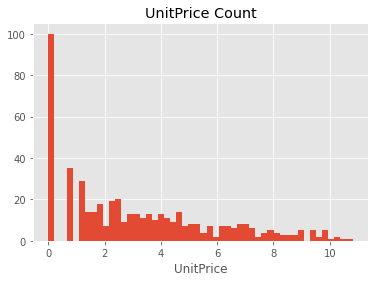

In [1036]:
unit_price = train_data.groupby(['UnitPrice']).count()
plt = plot_hist(np.log(unit_price['StockCode']),50)
plt.title('UnitPrice Count')
plt.xlabel('UnitPrice')
plt.show()
# up_key = unit_price.groups.keys()